# Imports

In [1]:
%load_ext autoreload
%autoreload 2
from collections import defaultdict
import pickle
import numpy as np
import sys
sys.path.append("../..")
from utils.diverse import *
from utils.data_transformations import *
from utils.visualization_tools import *
from sklearn.utils import resample

In [2]:
set_random_state(42)

Using TensorFlow backend.


In [3]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

# Load dataset

In [4]:
with open("../../../../main_experiment/sparse_data/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)
slow_wave_ids = list(dataset["sws"].keys())
print(len(slow_wave_ids))

3025


In [5]:
dataset["sws"][slow_wave_ids[0]].keys()

dict_keys(['file_id', 'gcamp_mean', 'gcamp_aligned', 'shape', 'gcamp_interpolated', 'hemo_aligned', 'hemo_interpolated', 'height', 'width', 'start', 'stop', 'correlation', 'nc_start', 'nc_stop', 'left_too_high', 'iso', 'gcamp_improved_interpolated', 'flow_components', 'mean_sources', 'mean_sinks'])

# Load data for features, select slow waves

In [6]:
def interpolate(y, n = 10):
    return interp1d(np.arange(len(y)), y)(np.linspace(0,len(y)-1, n))

In [ ]:
# Get features
features = ["iso", "start", "stop", "width", "height", "gcamp_interpolated", "gcamp_mean", 
            "hemo_interpolated", "left_too_high", "correlation", "mean_sources", "mean_sinks"]
iso, start, stop, width, height, gcamp, gcamp_mean, hemo, left_too_high, corr, mean_sources, mean_sinks = slow_wave_features(dataset, features)

#Filter waves and get all data for filtered indices (where)
where = corr < .3
where[height/width < 0.09] = False
where[left_too_high] = False
#where[height/width < 0.05] = False
print(str(np.sum(where)) + " samples selected")

# Get features for selected waves
iso, start, stop, width, height, gcamp, gcamp_mean, hemo, left_too_high, corr, mean_sources, mean_sinks = slow_wave_features(dataset, features, where)
flow_dir = [dataset["sws"][id]["flow_components"]["per_frame"]["left_hemisphere"] for id in slow_wave_ids]
flow_dir = [[interpolate(f[0], 128),interpolate(f[1], 128),interpolate(f[2], 128),interpolate(f[3], 128)] for f in flow_dir]
flow_dir = np.array(flow_dir)
flow_dir = flow_dir[where]
ud = flow_dir[:,0,:] - flow_dir[:,1,:]#up flow positive
lr = flow_dir[:,2,:] - flow_dir[:,3,:]
ud = (ud.T/np.nanmax([np.nanmax(ud, axis = 1), -np.nanmin(ud, axis = 1)], axis = 0)).T#Normalize per wave
lr = (lr.T/np.nanmax([np.nanmax(lr, axis = 1), -np.nanmin(lr, axis = 1)], axis = 0)).T

../../utils/diverse.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  feature = np.array([dataset["sws"][k][name] for k in slow_wave_ids])


233 samples selected


In [ ]:
up_in_time = np.abs(ud)
down_up_in_time = np.abs(ud)
up_in_time[ud < 0] = 0
down_up_in_time[ud > 0] = 0

up_in_time = gaussian_filter(up_in_time, [0,1])
down_in_time = gaussian_filter(down_up_in_time, [0,1])

In [ ]:
sources_sinks = [np.hstack([a, b]) for a,b in zip(mean_sources, mean_sinks)]

In [ ]:
fig, ax = plt.subplots(1, dpi = 100)
_ = ax.hist(height, bins = 100)
ax.set_xlabel("Amplitude [%]")
ax.set_ylabel("Absolute frequency")

In [ ]:
components = [dataset["sws"][id]["flow_components"]["per_wave"]["left_hemisphere"] for id in np.array(slow_wave_ids)[where]]
components = np.array(components)
relative_components = np.array([normalize(c) for c in components])
vertical_greater_horizontal = np.array([normalize(c) for c in components[:,1:3]])

In [ ]:
abs_up_flow = np.abs(components[:,2])
abs_down_flow = np.abs(components[:,3])
abs_left_flow = np.abs(components[:,0])
abs_right_flow = np.abs(components[:,1])

ud = abs_up_flow + abs_down_flow
lr = abs_right_flow + abs_left_flow
up_flow = abs_up_flow/ud#upwards flow as fraction of total upwards/downwards flow
left_flow = abs_left_flow/lr#upwards flow as fraction of total upwards/downwards flow

flow_per_auc = (ud+lr)/[np.nansum(x) for x in gcamp_mean]
ratio_vertical_horizontal = ud/(ud+lr)

# Flow in a direction as percent of total flow

In [13]:
total_flow = (abs_left_flow+abs_right_flow+abs_up_flow+abs_down_flow)
leftwards_by_tot = (abs_left_flow)/total_flow
rightwards_by_tot = (abs_right_flow)/total_flow
upwards_by_tot = (abs_up_flow)/total_flow
downwards_by_tot = (abs_down_flow)/total_flow

flow_by_tot = [leftwards_by_tot, rightwards_by_tot, upwards_by_tot, downwards_by_tot]

In [14]:
import pandas as pd
crosscorr = np.corrcoef([leftwards_by_tot, rightwards_by_tot, upwards_by_tot, downwards_by_tot])
df = pd.DataFrame(crosscorr, columns = ["Left","right", "up", "down"])
df.insert(0, column = "", value = ["Left","right", "up", "down"])
df

,,Left,right,up,down
0,Left,1.000000,0.617015,-0.111911,-0.724098
1,right,0.617015,1.000000,-0.129533,-0.717997
2,up,-0.111911,-0.129533,1.000000,-0.484360
3,down,-0.724098,-0.717997,-0.484360,1.000000


In [15]:
#abs_up_flow - abs_down_flow

In [16]:
#for uf in [up_flow[iso == i] for i in list(set(isos))]:
#    plt.scatter(np.arange(len(uf)), uf)
#    plt.plot([0,60], [np.mean(uf), np.mean(uf)])

## Prepare data

Use train test split to split the dataset. 

Append features that we aim to plot later such that they are split and shuffled in the same way.

In [17]:
from sklearn.model_selection import train_test_split
random_state = 42
test_size=.25

In [18]:
components = (components.T / np.max(components, axis = 1)).T

In [19]:
values = np.hstack([np.array([width]).T, np.array([height]).T])
values = normalize(values)

In [20]:
values = np.hstack([values,np.array(flow_by_tot).T])

In [21]:
sources_sinks_train, sources_sinks_test = train_test_split(sources_sinks, test_size=test_size, random_state = random_state)
vectors_train, vectors_test = train_test_split(gcamp, test_size=test_size, random_state = random_state)
values_train, values_test = train_test_split(values, test_size=test_size, random_state = random_state)

sources_sinks_train =  np.expand_dims(sources_sinks_train,-1)
sources_sinks_test =  np.expand_dims(sources_sinks_test,-1)
vectors_train = np.expand_dims(vectors_train,-1)
vectors_test = np.expand_dims(vectors_test, -1)

vectors_train = np.expand_dims(vectors_train,1)
vectors_test = np.expand_dims(vectors_test, -1)

Save additional features as variables.

In [22]:
additional_features = [iso, corr, width, height, ratio_vertical_horizontal, up_flow, left_flow, flow_per_auc]
additional_features = [train_test_split(f, test_size=test_size, random_state = random_state) for f in additional_features]
add_train = [f[0] for f in additional_features]
add_test = [f[1] for f in additional_features]
iso_train, corr_train, width_train, height_train, ratio_vertical_horizontal_train, up_flow_train, left_flow_train, flow_per_auc_train = add_train
iso_test, corr_test, width_test, height_test, ratio_vertical_horizontal_test, up_flow_test, left_flow_test, flow_per_auc_test = add_test

In [23]:
print("There are " + str(len(iso_test)) + " test samples")

There are 59 test samples


In [24]:
print("The maximal amplitude of the percentage change in time is " 
              + str(np.max(height_train).round()))

The maximal amplitude of the percentage change in time is 124.0


# Variational Autoenconder

In [25]:
## network parameters
from predictive_modeling.models.vae_cnn_v2 import *
from keras import Model

batch_size = 100
epochs = 200

n_values = 6

In [26]:
[image_input, value_input, vector_input], [z_mean, z_log_var, z] = encoder(n_values)
latent_inputs, [image_decoded, values_decoded, vector_decoded] = decoder(n_values)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


../../predictive_modeling/models/vae_cnn_v2.py:113: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (8, 8), input_shape=[64, 128, ..., activation="relu", strides=(4, 4))`
  image_model.add(Conv2D(32, (8, 8), subsample=(4, 4), input_shape=[64, 128,1], activation = "relu"))
../../predictive_modeling/models/vae_cnn_v2.py:114: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (4, 4), activation="relu", strides=(2, 2))`
  image_model.add(Conv2D(64, (4, 4), subsample=(2, 2), activation = "relu"))
../../predictive_modeling/models/vae_cnn_v2.py:115: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", strides=(1, 1))`
  image_model.add(Conv2D(64, (3, 3), subsample=(1, 1), activation = "relu"))


(None, 1, 128, 1)


In [27]:
encoder_model = Model(inputs = [image_input, value_input, vector_input], outputs = [z_mean, z_log_var, z])
decoder_model = Model(inputs = latent_inputs, outputs = [image_decoded, values_decoded, vector_decoded], name='decoder')

In [28]:
image_decoded, values_decoded, vector_decoded = decoder_model(encoder_model([image_input, value_input, vector_input])[2])

In [29]:
vae = Model(inputs = [image_input, value_input, vector_input], 
            outputs = [image_decoded, values_decoded, vector_decoded], name='vae_mlp')

In [30]:
print("The input shapes of the autoencoder are: ")
print(image_input.shape)
print(value_input.shape)
print(vector_input.shape)

The input shapes of the autoencoder are: 
(None, 64, 128, 1)
(None, 6)
(None, 1, 128, 1)


In [31]:
import keras
loss, loss_width_height, loss_signal_in_time, img_reconstruction_loss, loss_dirs = get_vae_loss(image_input, value_input, vector_input, image_decoded, values_decoded, vector_decoded, z_mean, z_log_var, impact_reconstruction_loss = 100)
vae.add_loss(loss)
vae.add_metric(loss_width_height, name='loss_width_height')
vae.add_metric(loss_dirs, name='loss_dirs')
vae.add_metric(loss_signal_in_time, name='loss_signal_in_time')
vae.add_metric(img_reconstruction_loss, name='img_reconstruction_loss')

vae.compile(optimizer= keras.optimizers.Adam(learning_rate=0.01))
vae.compile(optimizer = "adam")

/home/elerator/anaconda3/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


In [32]:
x_train_combined = [sources_sinks_train, values_train, vectors_train]

In [33]:
# train the autoencoder
history = vae.fit(x_train_combined, epochs= 1000, batch_size=batch_size, verbose=2)

Epoch 1/1000
 - 15s - loss: 1144.8061 - loss_width_height: 0.0931 - loss_dirs: 0.0881 - loss_signal_in_time: 0.1328 - img_reconstruction_loss: 0.0898
Epoch 2/1000
 - 2s - loss: 1535.2289 - loss_width_height: 0.1082 - loss_dirs: 0.0991 - loss_signal_in_time: 0.1400 - img_reconstruction_loss: 0.7470
Epoch 3/1000
 - 2s - loss: 918.4936 - loss_width_height: 0.0463 - loss_dirs: 0.0796 - loss_signal_in_time: 0.1159 - img_reconstruction_loss: 0.0600
Epoch 4/1000
 - 2s - loss: 964.1201 - loss_width_height: 0.0636 - loss_dirs: 0.0799 - loss_signal_in_time: 0.1200 - img_reconstruction_loss: 0.0779
Epoch 5/1000
 - 2s - loss: 964.6324 - loss_width_height: 0.0679 - loss_dirs: 0.0783 - loss_signal_in_time: 0.1167 - img_reconstruction_loss: 0.0872
Epoch 6/1000
 - 2s - loss: 930.4351 - loss_width_height: 0.0664 - loss_dirs: 0.0754 - loss_signal_in_time: 0.1126 - img_reconstruction_loss: 0.0903
Epoch 7/1000
 - 2s - loss: 876.0523 - loss_width_height: 0.0615 - loss_dirs: 0.0712 - loss_signal_in_time: 0.

Epoch 56/1000
 - 1s - loss: 483.8080 - loss_width_height: 0.0183 - loss_dirs: 0.0507 - loss_signal_in_time: 0.0475 - img_reconstruction_loss: 0.0351
Epoch 57/1000
 - 1s - loss: 482.2666 - loss_width_height: 0.0171 - loss_dirs: 0.0511 - loss_signal_in_time: 0.0475 - img_reconstruction_loss: 0.0351
Epoch 58/1000
 - 1s - loss: 483.2592 - loss_width_height: 0.0179 - loss_dirs: 0.0512 - loss_signal_in_time: 0.0477 - img_reconstruction_loss: 0.0353
Epoch 59/1000
 - 1s - loss: 481.9993 - loss_width_height: 0.0168 - loss_dirs: 0.0513 - loss_signal_in_time: 0.0472 - img_reconstruction_loss: 0.0351
Epoch 60/1000
 - 1s - loss: 476.1756 - loss_width_height: 0.0161 - loss_dirs: 0.0512 - loss_signal_in_time: 0.0469 - img_reconstruction_loss: 0.0350
Epoch 61/1000
 - 1s - loss: 472.0296 - loss_width_height: 0.0164 - loss_dirs: 0.0501 - loss_signal_in_time: 0.0469 - img_reconstruction_loss: 0.0351
Epoch 62/1000
 - 1s - loss: 473.4487 - loss_width_height: 0.0169 - loss_dirs: 0.0509 - loss_signal_in_time

Epoch 111/1000
 - 1s - loss: 322.1656 - loss_width_height: 0.0045 - loss_dirs: 0.0373 - loss_signal_in_time: 0.0304 - img_reconstruction_loss: 0.0288
Epoch 112/1000
 - 1s - loss: 320.1298 - loss_width_height: 0.0047 - loss_dirs: 0.0373 - loss_signal_in_time: 0.0294 - img_reconstruction_loss: 0.0285
Epoch 113/1000
 - 1s - loss: 320.3284 - loss_width_height: 0.0046 - loss_dirs: 0.0373 - loss_signal_in_time: 0.0293 - img_reconstruction_loss: 0.0286
Epoch 114/1000
 - 1s - loss: 320.1023 - loss_width_height: 0.0045 - loss_dirs: 0.0375 - loss_signal_in_time: 0.0293 - img_reconstruction_loss: 0.0282
Epoch 115/1000
 - 1s - loss: 319.0449 - loss_width_height: 0.0046 - loss_dirs: 0.0375 - loss_signal_in_time: 0.0286 - img_reconstruction_loss: 0.0283
Epoch 116/1000
 - 1s - loss: 318.1239 - loss_width_height: 0.0046 - loss_dirs: 0.0376 - loss_signal_in_time: 0.0289 - img_reconstruction_loss: 0.0284
Epoch 117/1000
 - 1s - loss: 317.7694 - loss_width_height: 0.0044 - loss_dirs: 0.0367 - loss_signal_

Epoch 166/1000
 - 1s - loss: 300.6577 - loss_width_height: 0.0037 - loss_dirs: 0.0364 - loss_signal_in_time: 0.0243 - img_reconstruction_loss: 0.0258
Epoch 167/1000
 - 1s - loss: 300.8349 - loss_width_height: 0.0036 - loss_dirs: 0.0365 - loss_signal_in_time: 0.0242 - img_reconstruction_loss: 0.0257
Epoch 168/1000
 - 1s - loss: 300.2682 - loss_width_height: 0.0037 - loss_dirs: 0.0356 - loss_signal_in_time: 0.0240 - img_reconstruction_loss: 0.0254
Epoch 169/1000
 - 1s - loss: 300.5211 - loss_width_height: 0.0036 - loss_dirs: 0.0362 - loss_signal_in_time: 0.0243 - img_reconstruction_loss: 0.0256
Epoch 170/1000
 - 1s - loss: 300.0365 - loss_width_height: 0.0038 - loss_dirs: 0.0363 - loss_signal_in_time: 0.0241 - img_reconstruction_loss: 0.0255
Epoch 171/1000
 - 1s - loss: 299.9390 - loss_width_height: 0.0036 - loss_dirs: 0.0365 - loss_signal_in_time: 0.0238 - img_reconstruction_loss: 0.0255
Epoch 172/1000
 - 1s - loss: 299.8313 - loss_width_height: 0.0037 - loss_dirs: 0.0365 - loss_signal_

Epoch 221/1000
 - 1s - loss: 287.7160 - loss_width_height: 0.0034 - loss_dirs: 0.0356 - loss_signal_in_time: 0.0185 - img_reconstruction_loss: 0.0240
Epoch 222/1000
 - 1s - loss: 287.6191 - loss_width_height: 0.0036 - loss_dirs: 0.0360 - loss_signal_in_time: 0.0190 - img_reconstruction_loss: 0.0240
Epoch 223/1000
 - 1s - loss: 286.7893 - loss_width_height: 0.0035 - loss_dirs: 0.0359 - loss_signal_in_time: 0.0185 - img_reconstruction_loss: 0.0238
Epoch 224/1000
 - 1s - loss: 287.1241 - loss_width_height: 0.0035 - loss_dirs: 0.0363 - loss_signal_in_time: 0.0187 - img_reconstruction_loss: 0.0240
Epoch 225/1000
 - 2s - loss: 286.4810 - loss_width_height: 0.0034 - loss_dirs: 0.0361 - loss_signal_in_time: 0.0180 - img_reconstruction_loss: 0.0239
Epoch 226/1000
 - 1s - loss: 286.3652 - loss_width_height: 0.0035 - loss_dirs: 0.0359 - loss_signal_in_time: 0.0182 - img_reconstruction_loss: 0.0239
Epoch 227/1000
 - 1s - loss: 286.3802 - loss_width_height: 0.0036 - loss_dirs: 0.0357 - loss_signal_

Epoch 276/1000
 - 2s - loss: 279.4513 - loss_width_height: 0.0033 - loss_dirs: 0.0357 - loss_signal_in_time: 0.0156 - img_reconstruction_loss: 0.0231
Epoch 277/1000
 - 1s - loss: 278.8307 - loss_width_height: 0.0035 - loss_dirs: 0.0351 - loss_signal_in_time: 0.0155 - img_reconstruction_loss: 0.0231
Epoch 278/1000
 - 1s - loss: 278.4338 - loss_width_height: 0.0032 - loss_dirs: 0.0359 - loss_signal_in_time: 0.0153 - img_reconstruction_loss: 0.0233
Epoch 279/1000
 - 1s - loss: 278.2596 - loss_width_height: 0.0035 - loss_dirs: 0.0351 - loss_signal_in_time: 0.0151 - img_reconstruction_loss: 0.0229
Epoch 280/1000
 - 1s - loss: 277.3526 - loss_width_height: 0.0034 - loss_dirs: 0.0359 - loss_signal_in_time: 0.0152 - img_reconstruction_loss: 0.0230
Epoch 281/1000
 - 1s - loss: 277.1099 - loss_width_height: 0.0033 - loss_dirs: 0.0355 - loss_signal_in_time: 0.0149 - img_reconstruction_loss: 0.0229
Epoch 282/1000
 - 1s - loss: 277.6244 - loss_width_height: 0.0034 - loss_dirs: 0.0358 - loss_signal_

Epoch 331/1000
 - 1s - loss: 272.9611 - loss_width_height: 0.0034 - loss_dirs: 0.0356 - loss_signal_in_time: 0.0135 - img_reconstruction_loss: 0.0223
Epoch 332/1000
 - 1s - loss: 272.6478 - loss_width_height: 0.0034 - loss_dirs: 0.0356 - loss_signal_in_time: 0.0131 - img_reconstruction_loss: 0.0225
Epoch 333/1000
 - 1s - loss: 271.4866 - loss_width_height: 0.0034 - loss_dirs: 0.0358 - loss_signal_in_time: 0.0128 - img_reconstruction_loss: 0.0219
Epoch 334/1000
 - 1s - loss: 271.2789 - loss_width_height: 0.0034 - loss_dirs: 0.0358 - loss_signal_in_time: 0.0128 - img_reconstruction_loss: 0.0222
Epoch 335/1000
 - 1s - loss: 270.8314 - loss_width_height: 0.0035 - loss_dirs: 0.0352 - loss_signal_in_time: 0.0122 - img_reconstruction_loss: 0.0222
Epoch 336/1000
 - 1s - loss: 270.4567 - loss_width_height: 0.0034 - loss_dirs: 0.0352 - loss_signal_in_time: 0.0124 - img_reconstruction_loss: 0.0222
Epoch 337/1000
 - 1s - loss: 269.9368 - loss_width_height: 0.0033 - loss_dirs: 0.0352 - loss_signal_

Epoch 386/1000
 - 1s - loss: 265.6943 - loss_width_height: 0.0032 - loss_dirs: 0.0348 - loss_signal_in_time: 0.0107 - img_reconstruction_loss: 0.0216
Epoch 387/1000
 - 1s - loss: 266.0696 - loss_width_height: 0.0033 - loss_dirs: 0.0344 - loss_signal_in_time: 0.0113 - img_reconstruction_loss: 0.0211
Epoch 388/1000
 - 1s - loss: 266.3298 - loss_width_height: 0.0034 - loss_dirs: 0.0353 - loss_signal_in_time: 0.0110 - img_reconstruction_loss: 0.0215
Epoch 389/1000
 - 1s - loss: 266.3790 - loss_width_height: 0.0033 - loss_dirs: 0.0354 - loss_signal_in_time: 0.0114 - img_reconstruction_loss: 0.0212
Epoch 390/1000
 - 1s - loss: 266.9412 - loss_width_height: 0.0033 - loss_dirs: 0.0349 - loss_signal_in_time: 0.0111 - img_reconstruction_loss: 0.0214
Epoch 391/1000
 - 1s - loss: 266.1479 - loss_width_height: 0.0033 - loss_dirs: 0.0350 - loss_signal_in_time: 0.0112 - img_reconstruction_loss: 0.0216
Epoch 392/1000
 - 1s - loss: 265.6043 - loss_width_height: 0.0033 - loss_dirs: 0.0346 - loss_signal_

Epoch 441/1000
 - 1s - loss: 262.5527 - loss_width_height: 0.0031 - loss_dirs: 0.0347 - loss_signal_in_time: 0.0101 - img_reconstruction_loss: 0.0204
Epoch 442/1000
 - 2s - loss: 263.2797 - loss_width_height: 0.0032 - loss_dirs: 0.0354 - loss_signal_in_time: 0.0102 - img_reconstruction_loss: 0.0205
Epoch 443/1000
 - 2s - loss: 262.2456 - loss_width_height: 0.0032 - loss_dirs: 0.0349 - loss_signal_in_time: 0.0099 - img_reconstruction_loss: 0.0204
Epoch 444/1000
 - 1s - loss: 261.7613 - loss_width_height: 0.0031 - loss_dirs: 0.0348 - loss_signal_in_time: 0.0099 - img_reconstruction_loss: 0.0204
Epoch 445/1000
 - 1s - loss: 262.0615 - loss_width_height: 0.0032 - loss_dirs: 0.0348 - loss_signal_in_time: 0.0101 - img_reconstruction_loss: 0.0207
Epoch 446/1000
 - 1s - loss: 261.8179 - loss_width_height: 0.0031 - loss_dirs: 0.0356 - loss_signal_in_time: 0.0100 - img_reconstruction_loss: 0.0204
Epoch 447/1000
 - 1s - loss: 261.4821 - loss_width_height: 0.0032 - loss_dirs: 0.0352 - loss_signal_

Epoch 496/1000
 - 1s - loss: 261.6022 - loss_width_height: 0.0030 - loss_dirs: 0.0347 - loss_signal_in_time: 0.0103 - img_reconstruction_loss: 0.0199
Epoch 497/1000
 - 2s - loss: 261.8819 - loss_width_height: 0.0030 - loss_dirs: 0.0345 - loss_signal_in_time: 0.0101 - img_reconstruction_loss: 0.0202
Epoch 498/1000
 - 2s - loss: 261.8999 - loss_width_height: 0.0031 - loss_dirs: 0.0353 - loss_signal_in_time: 0.0100 - img_reconstruction_loss: 0.0201
Epoch 499/1000
 - 1s - loss: 262.2282 - loss_width_height: 0.0033 - loss_dirs: 0.0345 - loss_signal_in_time: 0.0100 - img_reconstruction_loss: 0.0198
Epoch 500/1000
 - 1s - loss: 261.4976 - loss_width_height: 0.0033 - loss_dirs: 0.0346 - loss_signal_in_time: 0.0098 - img_reconstruction_loss: 0.0196
Epoch 501/1000
 - 1s - loss: 260.9943 - loss_width_height: 0.0031 - loss_dirs: 0.0354 - loss_signal_in_time: 0.0096 - img_reconstruction_loss: 0.0199
Epoch 502/1000
 - 1s - loss: 261.1724 - loss_width_height: 0.0032 - loss_dirs: 0.0344 - loss_signal_

Epoch 551/1000
 - 1s - loss: 258.8568 - loss_width_height: 0.0030 - loss_dirs: 0.0346 - loss_signal_in_time: 0.0091 - img_reconstruction_loss: 0.0192
Epoch 552/1000
 - 1s - loss: 259.0867 - loss_width_height: 0.0030 - loss_dirs: 0.0344 - loss_signal_in_time: 0.0094 - img_reconstruction_loss: 0.0194
Epoch 553/1000
 - 1s - loss: 259.1895 - loss_width_height: 0.0030 - loss_dirs: 0.0342 - loss_signal_in_time: 0.0093 - img_reconstruction_loss: 0.0192
Epoch 554/1000
 - 1s - loss: 258.8362 - loss_width_height: 0.0030 - loss_dirs: 0.0348 - loss_signal_in_time: 0.0092 - img_reconstruction_loss: 0.0189
Epoch 555/1000
 - 1s - loss: 258.8225 - loss_width_height: 0.0030 - loss_dirs: 0.0343 - loss_signal_in_time: 0.0089 - img_reconstruction_loss: 0.0192
Epoch 556/1000
 - 1s - loss: 258.7580 - loss_width_height: 0.0031 - loss_dirs: 0.0350 - loss_signal_in_time: 0.0094 - img_reconstruction_loss: 0.0191
Epoch 557/1000
 - 1s - loss: 259.1568 - loss_width_height: 0.0031 - loss_dirs: 0.0343 - loss_signal_

Epoch 606/1000
 - 1s - loss: 257.3727 - loss_width_height: 0.0029 - loss_dirs: 0.0345 - loss_signal_in_time: 0.0086 - img_reconstruction_loss: 0.0187
Epoch 607/1000
 - 1s - loss: 257.1505 - loss_width_height: 0.0030 - loss_dirs: 0.0346 - loss_signal_in_time: 0.0087 - img_reconstruction_loss: 0.0186
Epoch 608/1000
 - 1s - loss: 256.8968 - loss_width_height: 0.0030 - loss_dirs: 0.0347 - loss_signal_in_time: 0.0085 - img_reconstruction_loss: 0.0186
Epoch 609/1000
 - 1s - loss: 257.0776 - loss_width_height: 0.0029 - loss_dirs: 0.0347 - loss_signal_in_time: 0.0087 - img_reconstruction_loss: 0.0188
Epoch 610/1000
 - 1s - loss: 257.4967 - loss_width_height: 0.0031 - loss_dirs: 0.0346 - loss_signal_in_time: 0.0087 - img_reconstruction_loss: 0.0185
Epoch 611/1000
 - 1s - loss: 257.2779 - loss_width_height: 0.0030 - loss_dirs: 0.0345 - loss_signal_in_time: 0.0086 - img_reconstruction_loss: 0.0190
Epoch 612/1000
 - 1s - loss: 258.0178 - loss_width_height: 0.0030 - loss_dirs: 0.0346 - loss_signal_

Epoch 661/1000
 - 1s - loss: 256.8352 - loss_width_height: 0.0029 - loss_dirs: 0.0346 - loss_signal_in_time: 0.0085 - img_reconstruction_loss: 0.0179
Epoch 662/1000
 - 1s - loss: 256.1153 - loss_width_height: 0.0030 - loss_dirs: 0.0344 - loss_signal_in_time: 0.0083 - img_reconstruction_loss: 0.0182
Epoch 663/1000
 - 1s - loss: 256.1323 - loss_width_height: 0.0030 - loss_dirs: 0.0347 - loss_signal_in_time: 0.0084 - img_reconstruction_loss: 0.0180
Epoch 664/1000
 - 1s - loss: 255.6570 - loss_width_height: 0.0031 - loss_dirs: 0.0344 - loss_signal_in_time: 0.0082 - img_reconstruction_loss: 0.0178
Epoch 665/1000
 - 1s - loss: 256.3173 - loss_width_height: 0.0029 - loss_dirs: 0.0342 - loss_signal_in_time: 0.0083 - img_reconstruction_loss: 0.0180
Epoch 666/1000
 - 1s - loss: 256.1742 - loss_width_height: 0.0029 - loss_dirs: 0.0347 - loss_signal_in_time: 0.0083 - img_reconstruction_loss: 0.0181
Epoch 667/1000
 - 1s - loss: 256.5161 - loss_width_height: 0.0030 - loss_dirs: 0.0344 - loss_signal_

Epoch 716/1000
 - 1s - loss: 255.7221 - loss_width_height: 0.0029 - loss_dirs: 0.0349 - loss_signal_in_time: 0.0081 - img_reconstruction_loss: 0.0178
Epoch 717/1000
 - 1s - loss: 255.8177 - loss_width_height: 0.0029 - loss_dirs: 0.0344 - loss_signal_in_time: 0.0082 - img_reconstruction_loss: 0.0180
Epoch 718/1000
 - 1s - loss: 256.4486 - loss_width_height: 0.0030 - loss_dirs: 0.0348 - loss_signal_in_time: 0.0083 - img_reconstruction_loss: 0.0175
Epoch 719/1000
 - 1s - loss: 255.3728 - loss_width_height: 0.0028 - loss_dirs: 0.0341 - loss_signal_in_time: 0.0079 - img_reconstruction_loss: 0.0178
Epoch 720/1000
 - 1s - loss: 256.0406 - loss_width_height: 0.0029 - loss_dirs: 0.0344 - loss_signal_in_time: 0.0084 - img_reconstruction_loss: 0.0179
Epoch 721/1000
 - 1s - loss: 255.6145 - loss_width_height: 0.0030 - loss_dirs: 0.0345 - loss_signal_in_time: 0.0082 - img_reconstruction_loss: 0.0176
Epoch 722/1000
 - 1s - loss: 255.3577 - loss_width_height: 0.0029 - loss_dirs: 0.0345 - loss_signal_

Epoch 771/1000
 - 1s - loss: 254.3102 - loss_width_height: 0.0030 - loss_dirs: 0.0343 - loss_signal_in_time: 0.0077 - img_reconstruction_loss: 0.0173
Epoch 772/1000
 - 1s - loss: 254.7840 - loss_width_height: 0.0030 - loss_dirs: 0.0343 - loss_signal_in_time: 0.0078 - img_reconstruction_loss: 0.0173
Epoch 773/1000
 - 1s - loss: 255.2989 - loss_width_height: 0.0030 - loss_dirs: 0.0347 - loss_signal_in_time: 0.0078 - img_reconstruction_loss: 0.0173
Epoch 774/1000
 - 1s - loss: 254.5571 - loss_width_height: 0.0030 - loss_dirs: 0.0343 - loss_signal_in_time: 0.0079 - img_reconstruction_loss: 0.0172
Epoch 775/1000
 - 1s - loss: 254.3194 - loss_width_height: 0.0030 - loss_dirs: 0.0347 - loss_signal_in_time: 0.0078 - img_reconstruction_loss: 0.0171
Epoch 776/1000
 - 1s - loss: 255.0469 - loss_width_height: 0.0029 - loss_dirs: 0.0343 - loss_signal_in_time: 0.0079 - img_reconstruction_loss: 0.0172
Epoch 777/1000
 - 1s - loss: 254.7708 - loss_width_height: 0.0029 - loss_dirs: 0.0341 - loss_signal_

Epoch 826/1000
 - 1s - loss: 253.6212 - loss_width_height: 0.0028 - loss_dirs: 0.0345 - loss_signal_in_time: 0.0075 - img_reconstruction_loss: 0.0167
Epoch 827/1000
 - 1s - loss: 253.3063 - loss_width_height: 0.0029 - loss_dirs: 0.0340 - loss_signal_in_time: 0.0074 - img_reconstruction_loss: 0.0168
Epoch 828/1000
 - 1s - loss: 253.5925 - loss_width_height: 0.0030 - loss_dirs: 0.0347 - loss_signal_in_time: 0.0076 - img_reconstruction_loss: 0.0169
Epoch 829/1000
 - 1s - loss: 253.6895 - loss_width_height: 0.0029 - loss_dirs: 0.0340 - loss_signal_in_time: 0.0074 - img_reconstruction_loss: 0.0167
Epoch 830/1000
 - 1s - loss: 254.5194 - loss_width_height: 0.0029 - loss_dirs: 0.0346 - loss_signal_in_time: 0.0080 - img_reconstruction_loss: 0.0169
Epoch 831/1000
 - 1s - loss: 254.7600 - loss_width_height: 0.0029 - loss_dirs: 0.0342 - loss_signal_in_time: 0.0078 - img_reconstruction_loss: 0.0169
Epoch 832/1000
 - 1s - loss: 254.0122 - loss_width_height: 0.0029 - loss_dirs: 0.0342 - loss_signal_

Epoch 881/1000
 - 1s - loss: 254.7155 - loss_width_height: 0.0030 - loss_dirs: 0.0342 - loss_signal_in_time: 0.0077 - img_reconstruction_loss: 0.0167
Epoch 882/1000
 - 1s - loss: 253.4829 - loss_width_height: 0.0030 - loss_dirs: 0.0344 - loss_signal_in_time: 0.0074 - img_reconstruction_loss: 0.0161
Epoch 883/1000
 - 1s - loss: 253.2538 - loss_width_height: 0.0030 - loss_dirs: 0.0344 - loss_signal_in_time: 0.0075 - img_reconstruction_loss: 0.0164
Epoch 884/1000
 - 1s - loss: 254.2550 - loss_width_height: 0.0029 - loss_dirs: 0.0344 - loss_signal_in_time: 0.0075 - img_reconstruction_loss: 0.0165
Epoch 885/1000
 - 1s - loss: 254.4770 - loss_width_height: 0.0030 - loss_dirs: 0.0342 - loss_signal_in_time: 0.0077 - img_reconstruction_loss: 0.0168
Epoch 886/1000
 - 1s - loss: 254.9053 - loss_width_height: 0.0030 - loss_dirs: 0.0344 - loss_signal_in_time: 0.0074 - img_reconstruction_loss: 0.0166
Epoch 887/1000
 - 1s - loss: 254.3047 - loss_width_height: 0.0029 - loss_dirs: 0.0344 - loss_signal_

Epoch 936/1000
 - 1s - loss: 253.5631 - loss_width_height: 0.0029 - loss_dirs: 0.0344 - loss_signal_in_time: 0.0073 - img_reconstruction_loss: 0.0164
Epoch 937/1000
 - 1s - loss: 253.5204 - loss_width_height: 0.0029 - loss_dirs: 0.0343 - loss_signal_in_time: 0.0072 - img_reconstruction_loss: 0.0162
Epoch 938/1000
 - 1s - loss: 254.5886 - loss_width_height: 0.0030 - loss_dirs: 0.0344 - loss_signal_in_time: 0.0076 - img_reconstruction_loss: 0.0164
Epoch 939/1000
 - 2s - loss: 255.3951 - loss_width_height: 0.0030 - loss_dirs: 0.0344 - loss_signal_in_time: 0.0074 - img_reconstruction_loss: 0.0165
Epoch 940/1000
 - 2s - loss: 254.7448 - loss_width_height: 0.0030 - loss_dirs: 0.0344 - loss_signal_in_time: 0.0073 - img_reconstruction_loss: 0.0163
Epoch 941/1000
 - 1s - loss: 255.4639 - loss_width_height: 0.0029 - loss_dirs: 0.0350 - loss_signal_in_time: 0.0077 - img_reconstruction_loss: 0.0164
Epoch 942/1000
 - 1s - loss: 254.7837 - loss_width_height: 0.0029 - loss_dirs: 0.0344 - loss_signal_

Epoch 991/1000
 - 2s - loss: 252.1905 - loss_width_height: 0.0029 - loss_dirs: 0.0344 - loss_signal_in_time: 0.0070 - img_reconstruction_loss: 0.0156
Epoch 992/1000
 - 2s - loss: 252.1265 - loss_width_height: 0.0029 - loss_dirs: 0.0342 - loss_signal_in_time: 0.0073 - img_reconstruction_loss: 0.0159
Epoch 993/1000
 - 2s - loss: 252.3213 - loss_width_height: 0.0029 - loss_dirs: 0.0345 - loss_signal_in_time: 0.0069 - img_reconstruction_loss: 0.0154
Epoch 994/1000
 - 2s - loss: 252.2955 - loss_width_height: 0.0030 - loss_dirs: 0.0346 - loss_signal_in_time: 0.0070 - img_reconstruction_loss: 0.0159
Epoch 995/1000
 - 2s - loss: 252.8658 - loss_width_height: 0.0030 - loss_dirs: 0.0347 - loss_signal_in_time: 0.0071 - img_reconstruction_loss: 0.0156
Epoch 996/1000
 - 2s - loss: 253.0883 - loss_width_height: 0.0030 - loss_dirs: 0.0345 - loss_signal_in_time: 0.0070 - img_reconstruction_loss: 0.0157
Epoch 997/1000
 - 2s - loss: 253.0630 - loss_width_height: 0.0029 - loss_dirs: 0.0351 - loss_signal_

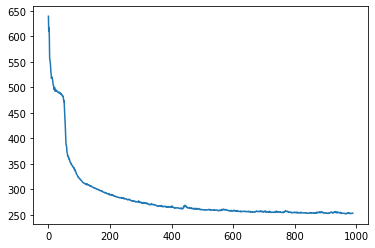

In [39]:
plt.plot(vae.history.history["loss"][10:])

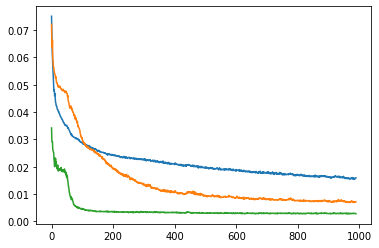

In [40]:
plt.plot(vae.history.history["img_reconstruction_loss"][10:])
plt.plot(vae.history.history["loss_signal_in_time"][10:])
plt.plot(vae.history.history["loss_width_height"][10:])
#plt.plot(vae.history.history["val_loss_direction"][10:])

# Visualize predictions

In [41]:
res = vae.predict(x_train_combined)

In [42]:
val_predictions = res[1]

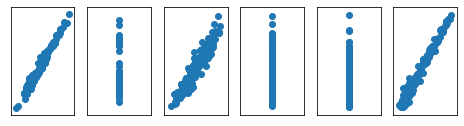

In [43]:
fig, ax = plt.subplots(1,6, figsize = (8,2))
for x, lab in enumerate(["width", "height", "up", "down", "left", "right"]):
    ax[x].scatter(val_predictions[:,0+x], values_train[:,0+x])
    ax[x].set_xticks([])
    ax[x].set_yticks([])

In [42]:
from scipy.ndimage import median_filter

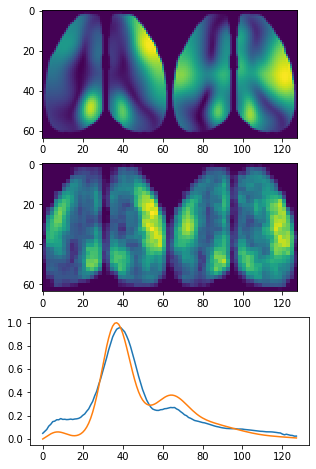

In [45]:
i = 1
fig, ax = plt.subplots(3, figsize= (5,8))
ax[0].imshow(sources_sinks_train[i][:,:,0])
ax[1].imshow(res[0][i][:,:,0])

ax[2].plot(res[2][i][0,:128,0])
ax[2].plot(vectors_train[i][0,:128,0])

In [505]:
from plots import manifold
from plots import manifold_of_images

In [506]:
#Predictions for z[0] and z[1] neurons i.e. x and y for the train and test datasets 
x_pred_train, y_pred_train = encoder_model.predict(x_train_combined)[2].T

FailedPreconditionError: Error while reading resource variable dense_31/bias from Container: localhost. This could mean that the variable was uninitialized. Not found: Container localhost does not exist. (Could not find resource: localhost/dense_31/bias)
	 [[{{node dense_31_1/BiasAdd/ReadVariableOp}}]]

In [ ]:
%%capture
x_min = np.mean(x_pred_train)-2*np.std(x_pred_train)
y_min = np.mean(y_pred_train)-2*np.std(y_pred_train)
x_max = np.mean(x_pred_train)+2*np.std(x_pred_train)
y_max = np.mean(y_pred_train)+2*np.std(y_pred_train)
x_range = [x_min, x_max]
y_range = [y_min, y_max]

man_mean_signal = manifold(decoder_model, x_range, y_range, n = 15, dpi = 300, scale="sqrt", multi_output = True)

In [ ]:
z_train = encoder_model.predict(x_train_combined)[2].T

fig, ax = plt.subplots(1,5, figsize= (10,5))
isos = [1.8, 2.0, 2.2, 2.4, 2.6]

def add_feature_plot(ax, iso):
    ax.scatter(*z_train, c= "lightgray")
    ax.scatter(*(z_train.T[iso_train == iso]).T, c = "darkblue")

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

for iso, a in zip(isos,ax):
    add_feature_plot(a, iso)

In [64]:
#%%capture
manifold_vector_components = manifold_of_vector_components(x_range = x_range, y_range = y_range, decoder_model = decoder_model, debug = True)

NameError: name 'manifold_of_vector_components' is not defined

In [63]:
sources_manifold = manifold_of_images(decoder_model, x_range, y_range, sources_sinks = "sources")
sinks_manifold = manifold_of_images(decoder_model, x_range, y_range, sources_sinks = "sinks")

In [ ]:
plt.plot(decoder_model.predict([[[2,2]]])[2][0,0,:,0])

In [ ]:
fig = plt.figure(constrained_layout = False, figsize = (10, 10), dpi = 500)
gs1 = fig.add_gridspec(nrows = 6, ncols = 4, left=0.05, right=0.48, wspace=0.05)
ax0 = fig.add_subplot(gs1[0:2, 0:2])
ax1 = fig.add_subplot(gs1[0:2, 2:4])
ax2 = fig.add_subplot(gs1[2:4, 0:2])
ax3 = fig.add_subplot(gs1[2:4, 2:4])
ax4 = fig.add_subplot(gs1[4:6, 0:2])
ax5 = fig.add_subplot(gs1[4:6, 2:4])

ax0.imshow(man_mean_signal)
ax1.imshow(manifold_vector_components)
ax2.imshow(man_mean_signal)
ax3.imshow(man_mean_signal)
ax4.imshow(sources_manifold)
ax5.imshow(sinks_manifold)

In [65]:
x_train.shape

(153, 130)

# Visualization

In [36]:
vae.save("full_vae")

In [41]:
vae = keras.models.load_model("full_vae", custom_objects={'tf': tf}, compile = False)